In [1]:
require 'nn'
require 'image'

cuda = false;
net = require "create_network"
network = 'small'

-- PUT IMAGE STUFF BACK
--
ImgLoader = require 'ImgLoader'
Predictions = require 'predictions'

dirpath = "images/"

if not dirpath or not paths.dirp(dirpath) then
  print ("directory " .. dirpath or "?" .. " isn't set or doesn't exist, using test images.");
  dirpath = ""
  img_list = ImgLoader:list_iter({
    "lena",
    "bee.jpg"
  })
else
  -- Iternate over all images in a path
  img_list = paths.files(dirpath)
end


==> #threads:	4	
==> init a small overfeat network	


nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> output]
  (1): nn.SpatialConvolution
  (2): nn.Threshold
  (3): nn.SpatialMaxPooling
  (4): nn.SpatialConvolutionMM
  (5): nn.Threshold
  (6): nn.SpatialMaxPooling
  (7): nn.SpatialZeroPadding
  (8): nn.SpatialConvolutionMM
  (9): nn.Threshold
  (10): nn.SpatialZeroPadding
  (11): nn.SpatialConvolutionMM
  (12): nn.Threshold
  (13): nn.SpatialZeroPadding
  (14): nn.SpatialConvolutionMM
  (15): nn.Threshold
  (16): nn.SpatialMaxPooling
  (17): nn.SpatialConvolutionMM
  (18): nn.Threshold
  (19): nn.SpatialConvolutionMM
  (20): nn.Threshold
  (21): nn.SpatialConvolutionMM
  (22): nn.View
  (23): nn.SoftMax
}
{
  output : FloatTensor - empty
  gradInput : FloatTensor - empty
  modules : 
    {
      1 : 
        nn.SpatialConvolution
        {
          bias : FloatTensor - size: 96
      

}
      2 : 
        nn.Threshold
        {
          val : 1e-06
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          threshold : 0
        }
      3 : 
        nn.SpatialMaxPooling
        {
          kW : 2
          kH : 2
          indices : FloatTensor - empty
          dW : 2
          gradInput : FloatTensor - empty
          output : FloatTensor - empty
          dH : 2
        }
      4 : 
        nn.SpatialConvolutionMM
        {
          padding : 0
          kW : 5
          nInputPlane : 96
          gradBias : FloatTensor - size: 256
          dW : 1
          gradWeight : FloatTensor - size: 256x2400
          output : FloatTensor - empty
          fgradInput : FloatTensor - empty
          finput : FloatTensor - empty
          bias : FloatTensor - size: 256
          weight : FloatTensor - size: 256x2400
          nOutputPlane : 256
          gradInput : FloatTensor - empty
          kH : 5
          dH : 1
        }
      5 : 
 

}
      8 : 
        nn.SpatialConvolutionMM
        {
          padding : 0
          kW : 3
          nInputPlane : 256
          gradBias : FloatTensor - size: 512
          dW : 1
          gradWeight : FloatTensor - size: 512x2304
          output : FloatTensor - empty
          fgradInput : FloatTensor - empty
          finput : FloatTensor - empty
          bias : FloatTensor - size: 512
          weight : FloatTensor - size: 512x2304
          nOutputPlane : 512
          gradInput : FloatTensor - empty
          kH : 3
          dH : 1
        }
      9 : 
        nn.Threshold
        {
          val : 1e-06
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          threshold : 0
        }
      10 : 
        nn.SpatialZeroPadding
        {
          pad_l : 1
          gradInput : FloatTensor - empty
          pad_t : 1
          pad_b : 1
          pad_r : 1
          output : FloatTensor - empty
        }
      11 : 
        nn.SpatialConvolu


        {
          kW : 2
          kH : 2
          indices : FloatTensor - empty
          dW : 2
          gradInput : FloatTensor - empty
          output : FloatTensor - empty
          dH : 2
        }
      17 : 
        nn.SpatialConvolutionMM
        {
          padding : 0
          kW : 6
          nInputPlane : 1024
          gradBias : FloatTensor - size: 3072
          dW : 1
          gradWeight : FloatTensor - size: 3072x36864
          output : FloatTensor - empty
          fgradInput : FloatTensor - empty
          finput : FloatTensor - empty
          bias : FloatTensor - size: 3072
          weight : FloatTensor - size: 3072x36864
          nOutputPlane : 3072
          gradInput : FloatTensor - empty
          kH : 6
          dH : 1
        }
      18 : 
        nn.Threshold
        {
          val : 1e-06
          output : FloatTensor - empty
          gradInput : FloatTensor - empty
          threshold : 0
        }
      19 : 
        nn.SpatialConvolutionM

File not found: images/.	
File not found: images/..	


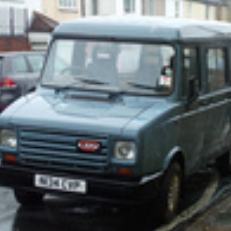

{
  1 : 
    {
      category_id : 269
      label : jeep, landrover
      confidence : 0.57328671216965
    }
  2 : 
    {
      category_id : 920
      label : minibus
      confidence : 0.19124059379101
    }
  3 : 
    {
      category_id : 285
      label : police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria
      confidence : 0.086482092738152
    }
}


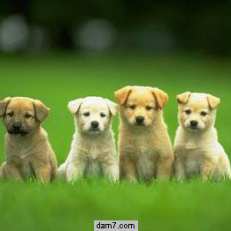

{
  1 : 
 

   {
      category_id : 176
      label : Labrador retriever
      confidence : 0.67448431253433
    }
  2 : 
    {
      category_id : 125
      label : golden retriever
      confidence : 0.29637351632118
    }
  3 : 
    {
      category_id : 141
      label : kuvasz
      confidence : 0.01944431476295
    }
}


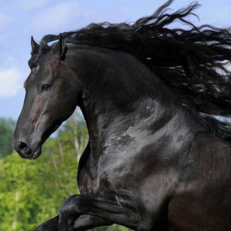

{
  1 : 
    {
      category_id : 17
      label : Great Dane
      confidence : 0.13726668059826
    }
  2 : 
    {
      category_id : 45
      label : Staffordshire bullterrier, Staffordshire bull terrier
      confidence : 0.12091673910618
    }
  3 : 
    {
      category_id : 36
      label : giant schnauzer
      confidence : 0.1057515963912
    }
}


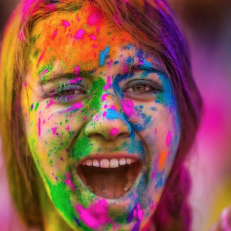

{
  1 : 
    {
      category_id : 992
      label : bubble
      confidence : 0.9887752532959
    }
  2 : 
    {
      category_id : 781
      label : mask
      confidence : 0.004151061642915
    }
  3 : 
    {
      category_id : 565
      label : pinwheel
      confidence : 0.0010720032732934
    }
}


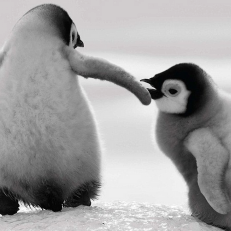

{
  1 : 
    {
      category_id : 441
      label : albatross, mollymawk
      confidence : 0.17185446619987
    }
  2 : 
    {
      category_id : 420
      label : goose
      confidence : 0.12280889600515
    }
  3 : 
    {
      category_id : 440
      label : king penguin, Aptenodytes patagonica
      confidence : 0.067308478057384
    }
}


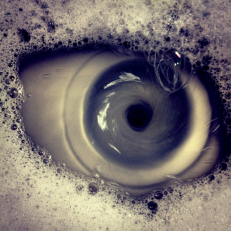

{
  1 : 
    {
      category_id : 650
      label : flatworm, platyhelminth
   

   confidence : 0.10784275084734
    }
  2 : 
    {
      category_id : 451
      label : eel
      confidence : 0.05949430167675
    }
  3 : 
    {
      category_id : 651
      label : nematode, nematode worm, roundworm
      confidence : 0.054595906287432
    }
}


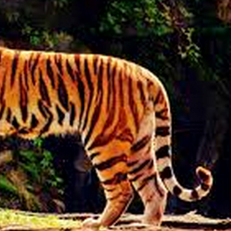

{
  1 : 
    {
      category_id : 76
      label : tiger, Panthera tigris
      confidence : 0.9213439822197
    }
  2 : 
    {
      category_id : 55
      label : tiger cat
      confidence : 0.075710020959377
    }
  3 : 
    {
      category_id : 201
      label : lynx, catamount
      confidence : 0.00043928308878094
    }
}


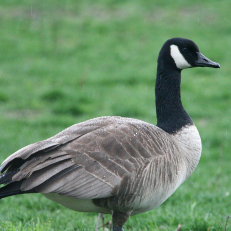

{
  1 : 
    {
      category_id : 420
      label : goose
      confidence : 1
    }
  2 : 
    {
      category_id : 667
      label : dishwasher, dish washer, dishwashing machine
      confidence : 0
    }
  3 : 
    {
      category_id : 666
      label : vacuum, vacuum cleaner
      confidence : 0
    }
}


In [2]:
for file in img_list do
  img = ImgLoader:load(dirpath .. file);
  if not img then goto continue end
  --itorch.image(img)
  itorch.image(img)
  output = net:forward(img)
  pred_a = Predictions:new{output = output}
  pred_a:init()
  pred_a:sort()
  print(pred_a:getN(3))
  ::continue::
  pred_a = nil
end